## 1. Iterative K-means clustering on Spark

Implement iterative K-means in Spark. We’ve provided you with starter code kmeans.py on Canvas, which takes care of data loading. Complete the logic inside the for loop, and run the code with different initialization strategies and loss functions. 

In [1]:
import operator
import sys
from pyspark import SparkConf, SparkContext
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg
from sklearn.manifold import TSNE
import time 
import pandas as pd
import random
%matplotlib inline

In [2]:
# Macros.
MAX_ITER = 20
DATA_PATH = "gs://6893_rita/q1/data.txt"
C1_PATH = "gs://6893_rita/q1/c1.txt"
C2_PATH = "gs://6893_rita/q1/c2.txt"

conf = SparkConf()
sc = SparkContext.getOrCreate(conf=conf)

# Load the data, cache this since we're accessing this each iteration
data = sc.textFile(DATA_PATH).map(lambda line: np.array([float(x) for x in line.split(' ')])).cache()
# Load the initial centroids c1, split into a list of np arrays
centroids1 = sc.textFile(C1_PATH).map(lambda line: np.array([float(x) for x in line.split(' ')])).collect()
# Load the initial centroids c2, split into a list of np arrays
centroids2 = sc.textFile(C2_PATH).map(lambda line: np.array([float(x) for x in line.split(' ')])).collect()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/10/06 04:29:30 INFO SparkEnv: Registering MapOutputTracker
23/10/06 04:29:30 INFO SparkEnv: Registering BlockManagerMaster
23/10/06 04:29:30 INFO SparkEnv: Registering BlockManagerMasterHeartbeat
23/10/06 04:29:30 INFO SparkEnv: Registering OutputCommitCoordinator


In [3]:
# Helper functions.
def closest(p, centroids, norm):
    """
    Compute closest centroid for a given point.
    Args:
        p (numpy.ndarray): input point
        centroids (list): A list of centroids points
        norm (int): 1 or 2
    Returns:
        int: The index of closest centroid.
    """
    closest_c = min([(i, linalg.norm(p - c, norm))for i,  c in enumerate(centroids)], key=operator.itemgetter(1))[0]
    return closest_c

In [4]:
# K-means clustering
def kmeans(data, centroids, norm):
    """
    Conduct k-means clustering given data and centroid.
    This is the basic version of k-means, you might need more
    code to record cluster assignment to plot TSNE, and more
    data structure to record cost.
    Args:
        data (RDD): RDD of points
        centroids (list): A list of centroids points
        norm (int): 1 or 2
    Returns:
        RDD: assignment information of points, a RDD of (centroid, (point, 1))
        list: a list of centroids
        and define yourself...
    """
    # iterative k-means
    costs = []
    
    for _ in range(MAX_ITER):
        # Transform each point to a combo of point, closest centroid, count=1
        # point -> (closest_centroid, (point, 1))
        combo = data.map(lambda point: (closest(point, centroids, norm), (point, 1))).cache()

        # Re-compute cluster center
        # For each cluster center (key), aggregate its values
        # by summing up points and count
        centroid_stats = combo.reduceByKey(lambda a, b: ([a[0][i] + b[0][i] for i in range(len(a[0]))], a[1] + b[1]))

        # Average the points for each centroid: divide sum of points by count
        centroids_rdd = centroid_stats.sortByKey().map(lambda x: [x[1][0][i] / x[1][1] for i in range(len(x[1][0]))])
        
        # Use collect() to turn RDD into list
        centroids = centroids_rdd.collect()
        
        # Calculate within-cluster cost and append it to the list
        within_cluster_cost = combo.map(lambda x: (x[0], linalg.norm(x[1][0] - centroids[x[0]], norm))) \
            .reduceByKey(lambda x, y: x + y).map(lambda x: x[1]).sum()
        costs.append(within_cluster_cost)

    # Collect cluster assignments for each point
    centroIndex = data.map(lambda point: closest(point, centroids, norm)).collect()
    
    return centroIndex, costs

**(1) Run clustering on data.txt with c1.txt and c2.txt as initial centroids and use L1 distance as similarity measurement. Compute and plot the within-cluster cost for each iteration. You’ll need to submit two graphs here. (10%)** 

In [5]:
centroIndex_c1_l1, costs_c1_l1 = kmeans(data, centroids1, norm=1)
centroIndex_c2_l1, costs_c2_l1 = kmeans(data, centroids2, norm=1)

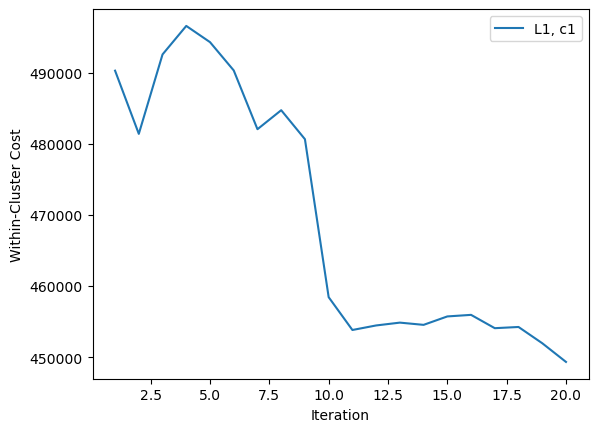

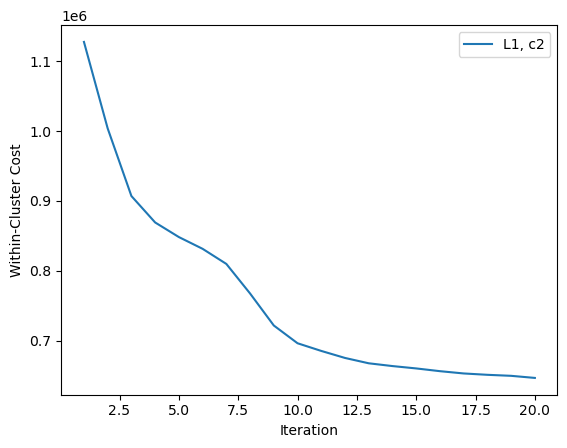

In [6]:
plt.plot(range(1, MAX_ITER + 1), costs_c1_l1, label='L1, c1')
plt.xlabel('Iteration')
plt.ylabel('Within-Cluster Cost')
plt.legend()
plt.show()

plt.plot(range(1, MAX_ITER + 1), costs_c2_l1, label='L1, c2')
plt.xlabel('Iteration')
plt.ylabel('Within-Cluster Cost')
plt.legend()
plt.show()

**(2) Run clustering on data.txt with c1.txt and c2.txt as initial centroids and use L2 distance as similarity measurement. Compute and plot the within-cluster cost for each iteration. You’ll need to submit two graphs here. (10%)** 

In [7]:
centroIndex_c1_l2, costs_c1_l2 = kmeans(data, centroids1, norm=2)
centroIndex_c2_l2, costs_c2_l2 = kmeans(data, centroids2, norm=2)

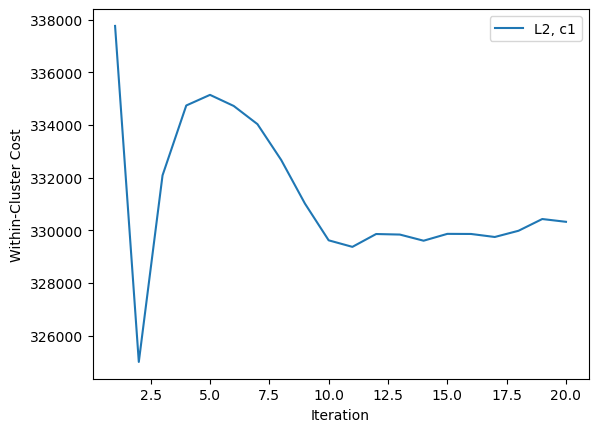

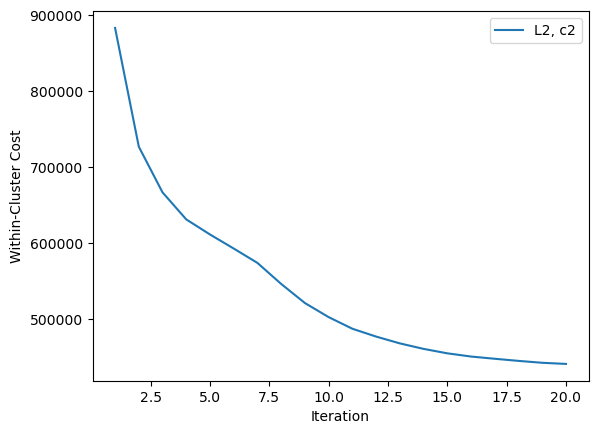

In [8]:
plt.plot(range(1, MAX_ITER + 1), costs_c1_l2, label='L2, c1')
plt.xlabel('Iteration')
plt.ylabel('Within-Cluster Cost')
plt.legend()
plt.show()

plt.plot(range(1, MAX_ITER + 1), costs_c2_l2, label='L2, c2')
plt.xlabel('Iteration')
plt.ylabel('Within-Cluster Cost')
plt.legend()
plt.show()

**(3) t-SNE is a dimensionality reduction method particularly suitable for visualization of high-dimensional data. Visualize your clustering assignment result of (2) by reducing the dimension to a 2D space. You’ll need to submit two graphs here. (5%)** 

In [9]:
# demensionality reduction
data_np = np.array(data.collect())
data_embedded = TSNE(n_components=2).fit_transform(data_np)
vis_x = data_embedded[:,0]
vis_y = data_embedded[:,1]

/opt/conda/miniconda3/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/conda/miniconda3/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


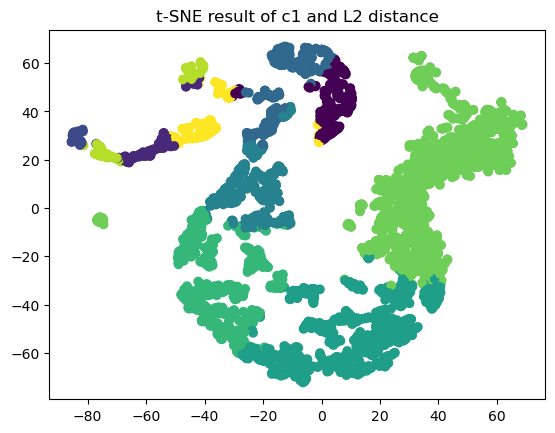

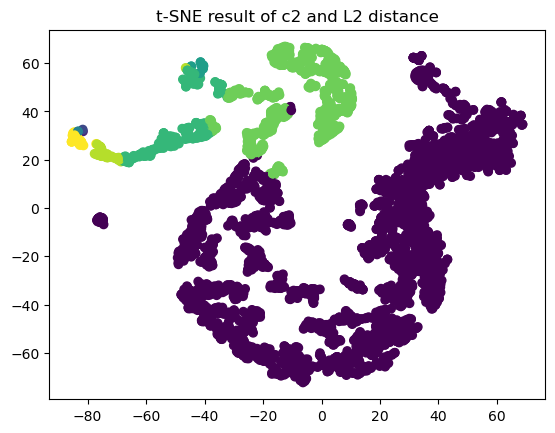

In [10]:
plt.scatter(vis_x, vis_y, c = centroIndex_c1_l2)
plt.title('t-SNE result of c1 and L2 distance')
plt.show()
plt.scatter(vis_x, vis_y, c = centroIndex_c2_l2)
plt.title('t-SNE result of c2 and L2 distance')
plt.show()

**(4) For L2 and L1 distance, are random initialization of K-means using c1.txt better than initialization using c2.txt in terms of cost? Explain your reasoning. (5%)** 

No, if the number of iterations is increased, the cost for both L2 and L1 distance by using c2.txt may eventually become lower than by using c1.txt. Random initialization (c1.txt) may lead to quicker convergence initially, but it can get stuck in suboptimal configurations, resulting in higher final within-cluster cost. Initialization with centroids as far away as possible (c2.txt) may take longer to converge initially but has the potential to find a better solution with lower final within-cluster cost with more iterations.

**(5) What is the time complexity of the iterative K-means? (5%)** 

For the number of clusters $ k $, data points $ p $, dimensions $ d $, and iterations $ n $: 

- Calculating Distances: For each of the $ p $  data points, the algorithm calculates the distance to each of the $ k $ centroids, resulting in a time complexity of $ O(n) = p * d * k $.

- Choosing Closest Centroids: The time complexity for choosing the closest centroids using QuickSort is given as $ O(n) = p * k * log(k) $.

- Recomputing Centroids: For recomputing the centroids, the algorithm aggregates points for each of the $ k $ clusters. The time complexity is $ O(n) = p * d $.

Therefore, time complexity of the iterative K-means is: $ O(n) = np(dk + k \log(k) + d) $


## 2. Binary Classification on Spark

**(1) Data loading: (7.5%)
Read the csv file into a Dataframe. You could set "inferschema" to true and rename the columns with the following information: "age", "workclass", "fnlwgt", "education", "education_num", "marital_status", "occupation", "relationship", "race", "sex", "capital_gain", "capital_loss", "hours_per_week", "native_country", "income". You could learn more about Dataframe from this doc.**

In [11]:
from pyspark.sql import SparkSession
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier
from pyspark.ml.classification import NaiveBayes, DecisionTreeClassifier, GBTClassifier 
from pyspark.ml.classification import MultilayerPerceptronClassifier, LinearSVC, OneVsRest
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
from pyspark.sql.functions import col
from functools import reduce

In [12]:
spark = SparkSession.builder.appName("BinaryClassificationOnSpark").getOrCreate()
df = spark.read.option("inferSchema", "true").csv("gs://6893_rita/adult.data")
df.show(3)

+---+-----------------+--------+----------+----+-------------------+------------------+--------------+------+-----+------+----+----+--------------+------+
|_c0|              _c1|     _c2|       _c3| _c4|                _c5|               _c6|           _c7|   _c8|  _c9|  _c10|_c11|_c12|          _c13|  _c14|
+---+-----------------+--------+----------+----+-------------------+------------------+--------------+------+-----+------+----+----+--------------+------+
| 39|        State-gov| 77516.0| Bachelors|13.0|      Never-married|      Adm-clerical| Not-in-family| White| Male|2174.0| 0.0|40.0| United-States| <=50K|
| 50| Self-emp-not-inc| 83311.0| Bachelors|13.0| Married-civ-spouse|   Exec-managerial|       Husband| White| Male|   0.0| 0.0|13.0| United-States| <=50K|
| 38|          Private|215646.0|   HS-grad| 9.0|           Divorced| Handlers-cleaners| Not-in-family| White| Male|   0.0| 0.0|40.0| United-States| <=50K|
+---+-----------------+--------+----------+----+-------------------+--

In [13]:
oldColumns = df.columns
newColumns = ("age", "workclass", "fnlwgt", "education", "education_num", "marital_status", "occupation", 
              "relationship", "race", "sex", "capital_gain", "capital_loss", "hours_per_week", "native_country", 
              "income")
df = reduce(lambda data, idx: data.withColumnRenamed(oldColumns[idx], newColumns[idx]), range(len(oldColumns)), df)
df.printSchema()
df.show(2)

root
 |-- age: integer (nullable = true)
 |-- workclass: string (nullable = true)
 |-- fnlwgt: double (nullable = true)
 |-- education: string (nullable = true)
 |-- education_num: double (nullable = true)
 |-- marital_status: string (nullable = true)
 |-- occupation: string (nullable = true)
 |-- relationship: string (nullable = true)
 |-- race: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- capital_gain: double (nullable = true)
 |-- capital_loss: double (nullable = true)
 |-- hours_per_week: double (nullable = true)
 |-- native_country: string (nullable = true)
 |-- income: string (nullable = true)

+---+-----------------+-------+----------+-------------+-------------------+----------------+--------------+------+-----+------------+------------+--------------+--------------+------+
|age|        workclass| fnlwgt| education|education_num|     marital_status|      occupation|  relationship|  race|  sex|capital_gain|capital_loss|hours_per_week|native_country|income|
+-

**(2) Data preprocessing: (7.5%) 
Convert the categorical variables into numeric variables with ML Pipelines and Feature Transformers. You will probably need OneHotEncoderEstimator, StringIndexer, and VectorAssembler. Split your data into the training and test sets, respectively, with a ratio of 70% and 30% and set the seed to 100.**

In [14]:
#stages in our Pipeline
stages = []
categoricalColumns = ["workclass","education","marital_status","occupation",
                      "relationship","race","sex","native_country"]

for categoricalCol in categoricalColumns:
    # Category Indexing with StringIndexer
    stringIndexer = StringIndexer(inputCol=categoricalCol, outputCol=categoricalCol + "Index")
    # Use OneHotEncoder to convert categorical variables into binary SparseVectors
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    # Add stages.  These are not run here, but will run all at once later on.
    stages += [stringIndexer, encoder]
    
# Convert label into label indices using the StringIndexer
label_stringIdx = StringIndexer(inputCol="income", outputCol="label")
stages += [label_stringIdx]

# Transform all features into a vector using VectorAssembler
numericCols = ["age", "fnlwgt", "education_num", "capital_gain", "capital_loss", "hours_per_week"]
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

pipeline = Pipeline(stages=stages)
pipelineModel = pipeline.fit(df)
preppedDataDF = pipelineModel.transform(df)
preppedDataDF.take(3)

23/10/06 04:32:50 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


[Row(age=39, workclass=' State-gov', fnlwgt=77516.0, education=' Bachelors', education_num=13.0, marital_status=' Never-married', occupation=' Adm-clerical', relationship=' Not-in-family', race=' White', sex=' Male', capital_gain=2174.0, capital_loss=0.0, hours_per_week=40.0, native_country=' United-States', income=' <=50K', workclassIndex=4.0, workclassclassVec=SparseVector(8, {4: 1.0}), educationIndex=2.0, educationclassVec=SparseVector(15, {2: 1.0}), marital_statusIndex=1.0, marital_statusclassVec=SparseVector(6, {1: 1.0}), occupationIndex=3.0, occupationclassVec=SparseVector(14, {3: 1.0}), relationshipIndex=1.0, relationshipclassVec=SparseVector(5, {1: 1.0}), raceIndex=0.0, raceclassVec=SparseVector(4, {0: 1.0}), sexIndex=0.0, sexclassVec=SparseVector(1, {0: 1.0}), native_countryIndex=0.0, native_countryclassVec=SparseVector(41, {0: 1.0}), label=0.0, features=SparseVector(100, {4: 1.0, 10: 1.0, 24: 1.0, 32: 1.0, 44: 1.0, 48: 1.0, 52: 1.0, 53: 1.0, 94: 39.0, 95: 77516.0, 96: 13.0, 9

In [15]:
# Keep relevant columns
cols = df.columns
selectedcols = ["label", "features"] + cols
preppedDataDF = preppedDataDF.select(selectedcols)
display(preppedDataDF)

# Randomly split data into training and test sets. set seed for reproducibility
trainingData, testData = preppedDataDF.randomSplit([0.7, 0.3], seed=100)
print(trainingData.count(), testData.count())

DataFrame[label: double, features: vector, age: int, workclass: string, fnlwgt: double, education: string, education_num: double, marital_status: string, occupation: string, relationship: string, race: string, sex: string, capital_gain: double, capital_loss: double, hours_per_week: double, native_country: string, income: string]

22832 9729


**(3) Modelling: (10%) 
Train logistic regression, Random Forest, Naive Bayes, Decision Tree, Gradient Boosting Trees, Multi-layer perceptron, Linear Support Vector Machine, One-vs Rest from Spark MLlib with the training set.** 

**(4) Evaluation: (10%) 
Apply all the models on the test set, analyze and compare their accuracies to rank these methods.**

In [16]:
# Modeling
lr = LogisticRegression(maxIter=10, featuresCol='features', labelCol='label')
rf = RandomForestClassifier(labelCol="label")
nb = NaiveBayes(labelCol="label")
dt = DecisionTreeClassifier(labelCol="label")
gbt = GBTClassifier(labelCol="label")
mlp = MultilayerPerceptronClassifier(layers=[len(assemblerInputs), 2, 2, 2], blockSize=128, 
                                     seed=1234, labelCol="label")
lsvc = LinearSVC(maxIter=10, regParam=0.1, labelCol="label")
ovr = OneVsRest(classifier=lsvc, labelCol="label")

models = [lr, rf, nb, dt, gbt, lsvc, ovr]

In [17]:
model_accuracies = []

for model in models:
    model_name = model.__class__.__name__
    print(f"Training {model_name}...")
    model = model.fit(trainingData)
    predictions = model.transform(testData)
    
    evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
    accuracy = evaluator.evaluate(predictions)
    print(f"{model_name} Test set accuracy = {accuracy}")
    model_accuracies.append((model_name, accuracy))
    
# Convert accuracy values to a DataFrame for easier analysis
df_accuracies = pd.DataFrame(model_accuracies, columns=["Model", "Accuracy"])
df_accuracies = df_accuracies.sort_values(by="Accuracy", ascending=False)

# Print or visualize the accuracy results
print("\nAccuracy Scores:")
print(df_accuracies)

Training LogisticRegression...


LogisticRegression Test set accuracy = 0.8468496248329735
Training RandomForestClassifier...


RandomForestClassifier Test set accuracy = 0.8232089628944393
Training NaiveBayes...


NaiveBayes Test set accuracy = 0.7796279165381849
Training DecisionTreeClassifier...


DecisionTreeClassifier Test set accuracy = 0.8406824956316168
Training GBTClassifier...


GBTClassifier Test set accuracy = 0.8507554733271662
Training LinearSVC...


LinearSVC Test set accuracy = 0.8348237228903279
Training OneVsRest...


OneVsRest Test set accuracy = 0.8348237228903279

Accuracy Scores:
                    Model  Accuracy
4           GBTClassifier  0.850755
0      LogisticRegression  0.846850
3  DecisionTreeClassifier  0.840682
5               LinearSVC  0.834824
6               OneVsRest  0.834824
1  RandomForestClassifier  0.823209
2              NaiveBayes  0.779628


In conclusion,
- GBTClassifier and LogisticRegression are the top-performing models in terms of accuracy.
- DecisionTreeClassifier, LinearSVC, and OneVsRest are also competitive and provide reasonable accuracy.
- RandomForestClassifier is slightly behind but still delivers a satisfactory performance.
- NaiveBayes has the lowest accuracy, possibly due to its assumptions about feature independence.


## 3. Monitoring Hadoop metrics

**(1) Download and setup Hadoop: (7.5%)**
Follow the download instructions in the corresponding tutorial we provide and install Hadoop in Pseudo Distributed Mode. Provide screenshots of each step in the “Verify Hadoop installation” section of the tutorial. 

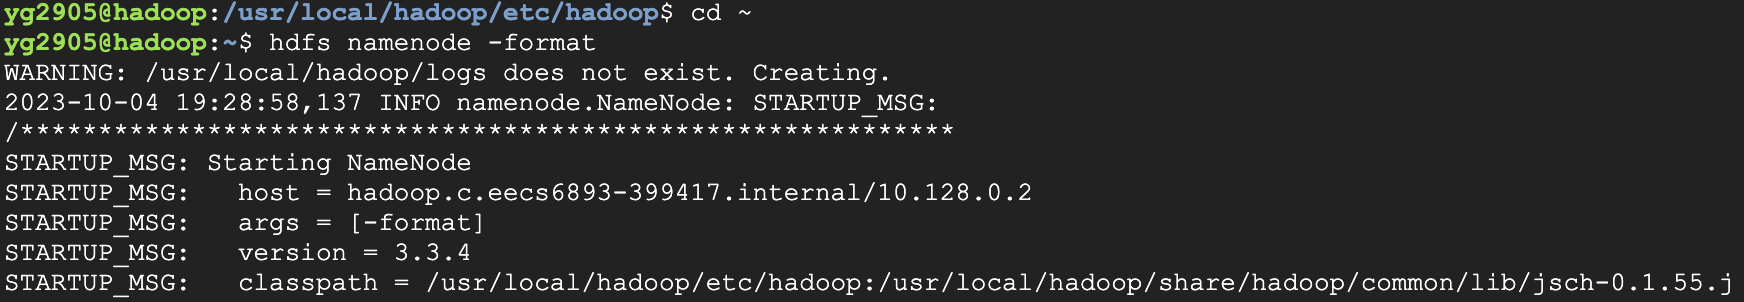
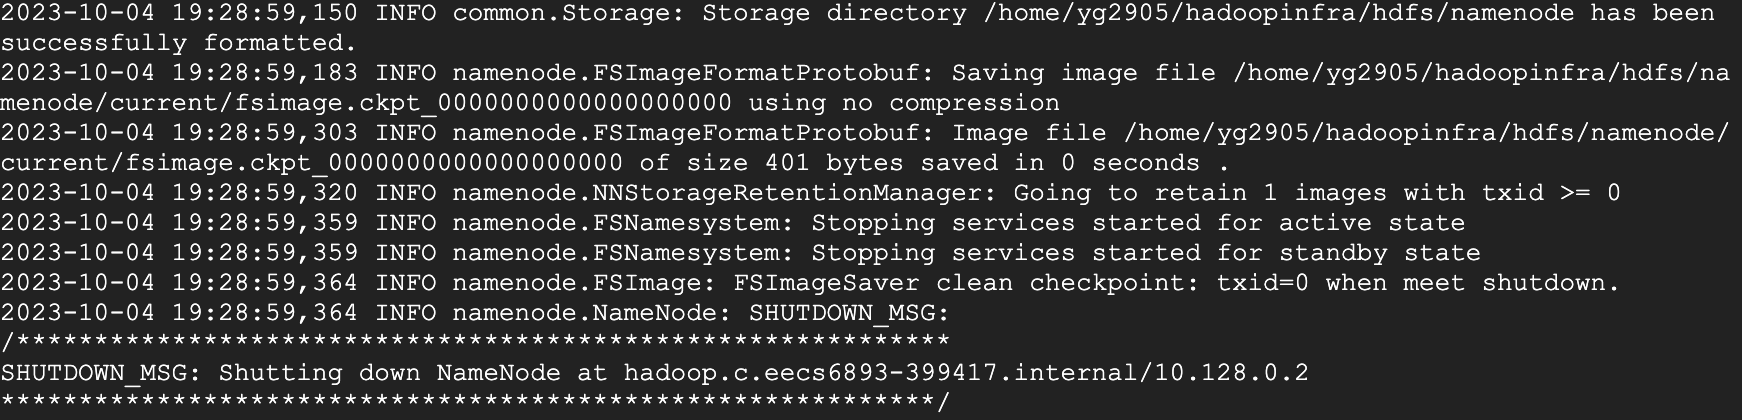
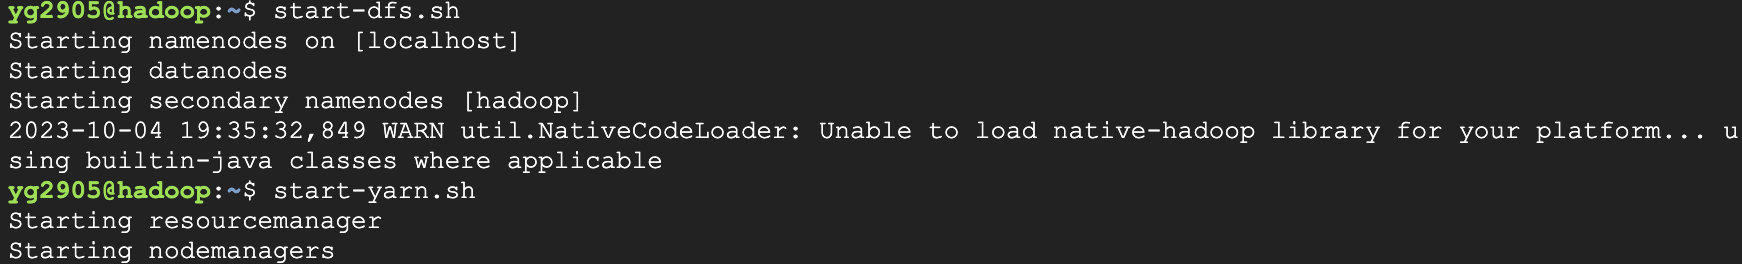

**(2) HDFS metrics monitoring: (7.5%)** 
- Monitor HDFS metrics through HTTP API. Provide a screenshot in your report. (3.75%) 
- Select five metrics that you think are most important. Explain their usages and why they are important. (3.75%) 

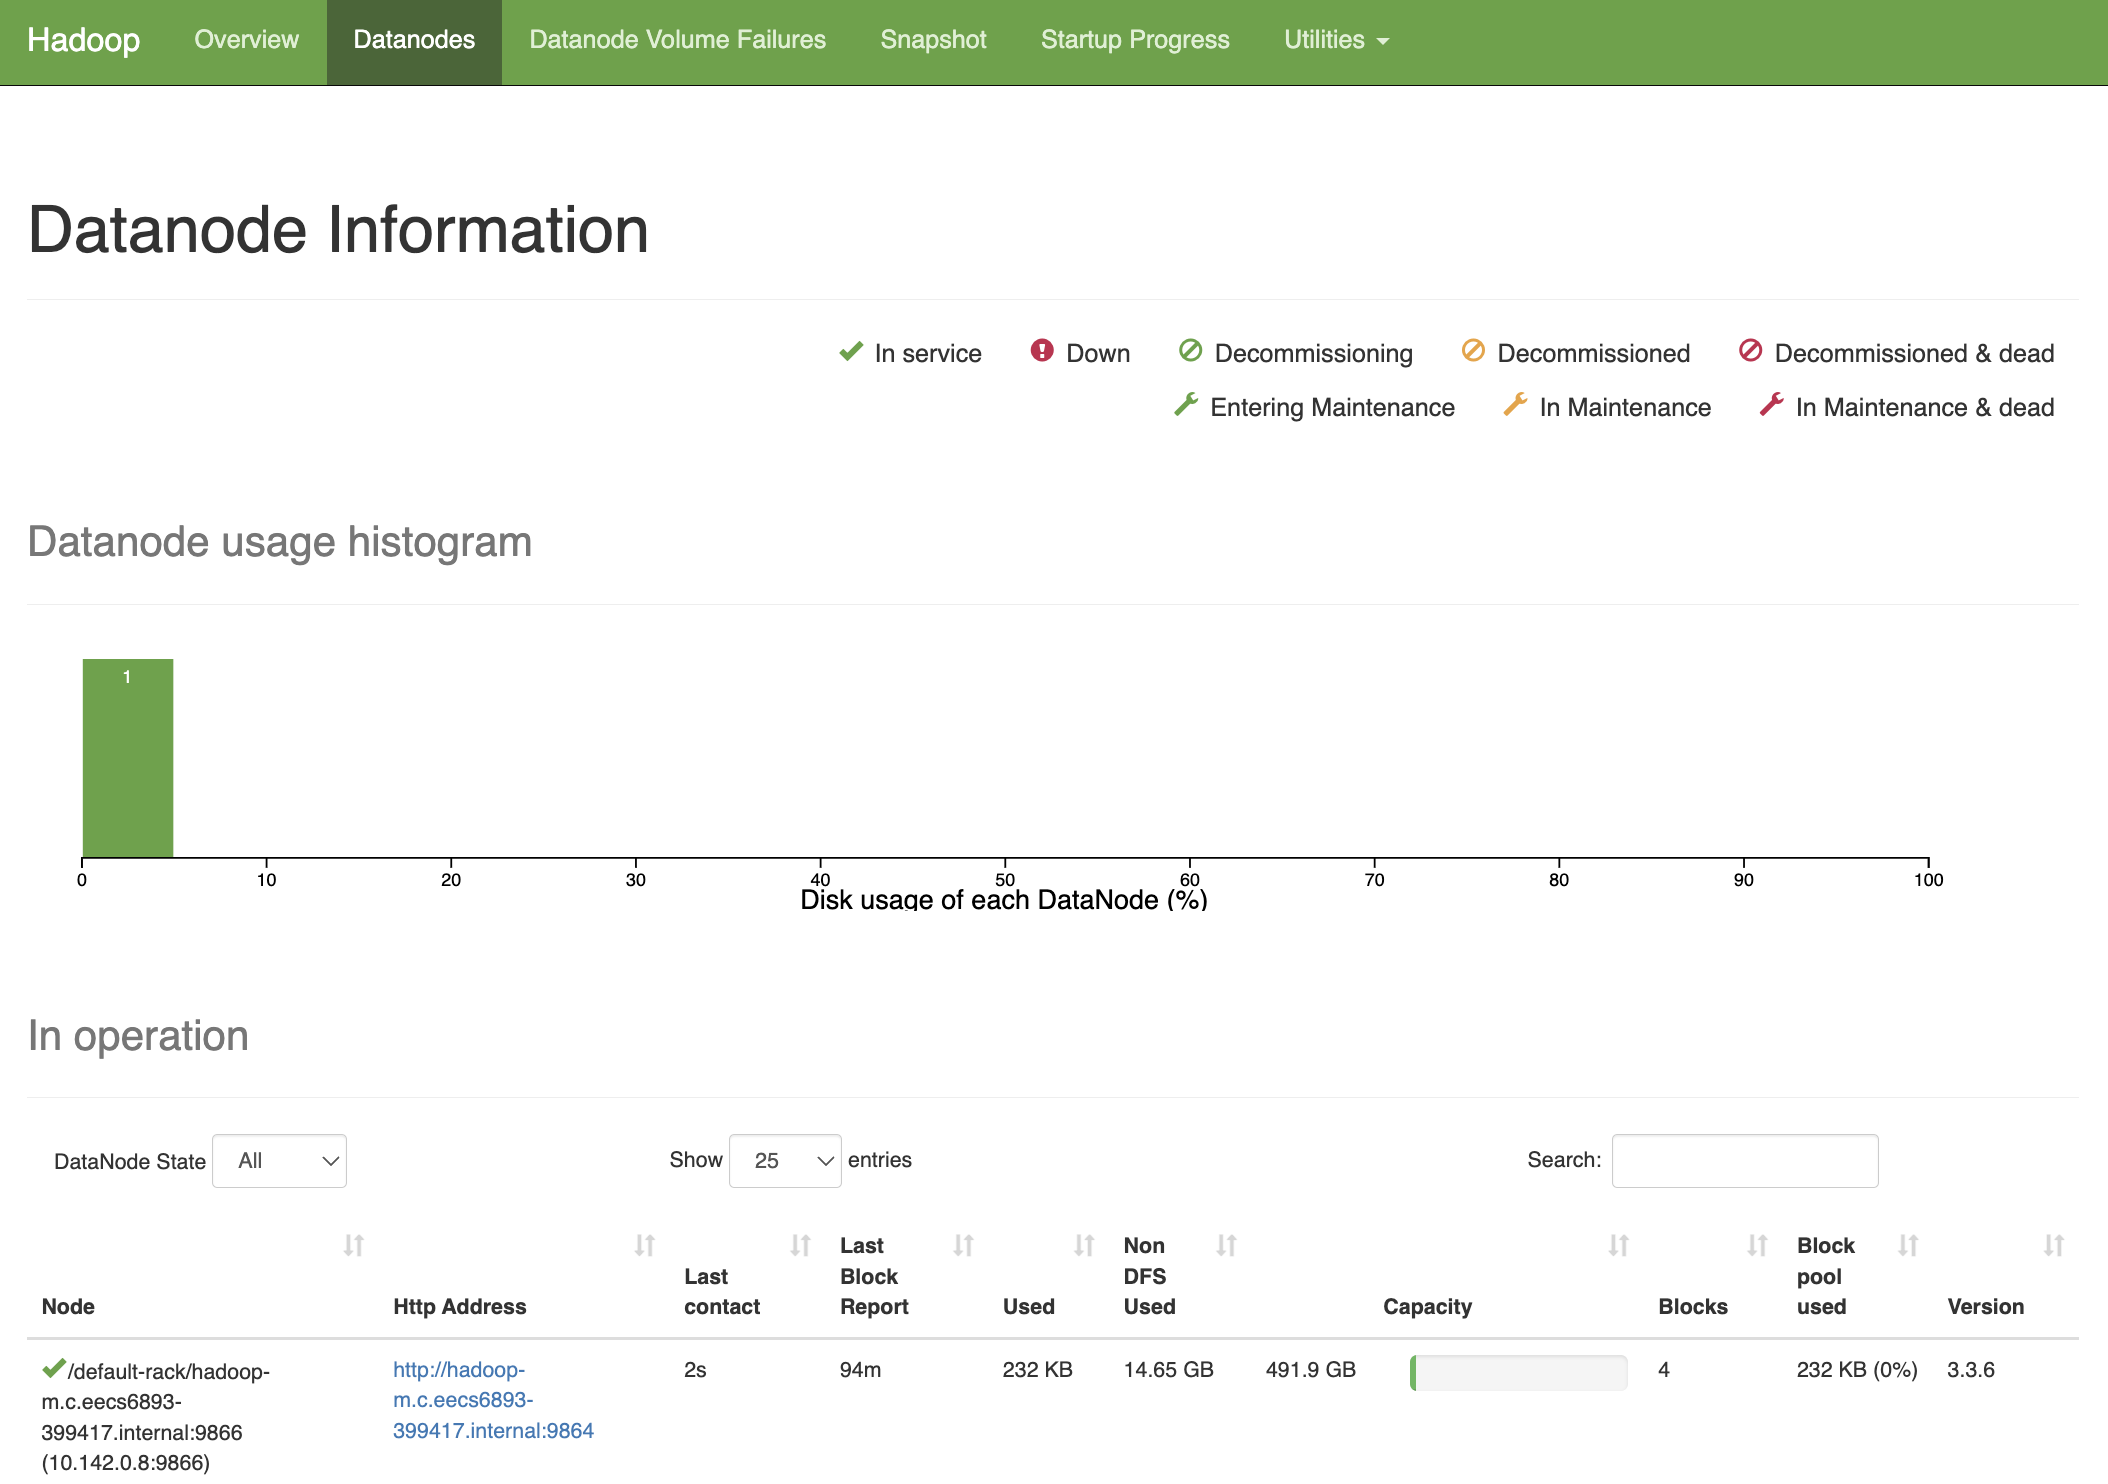

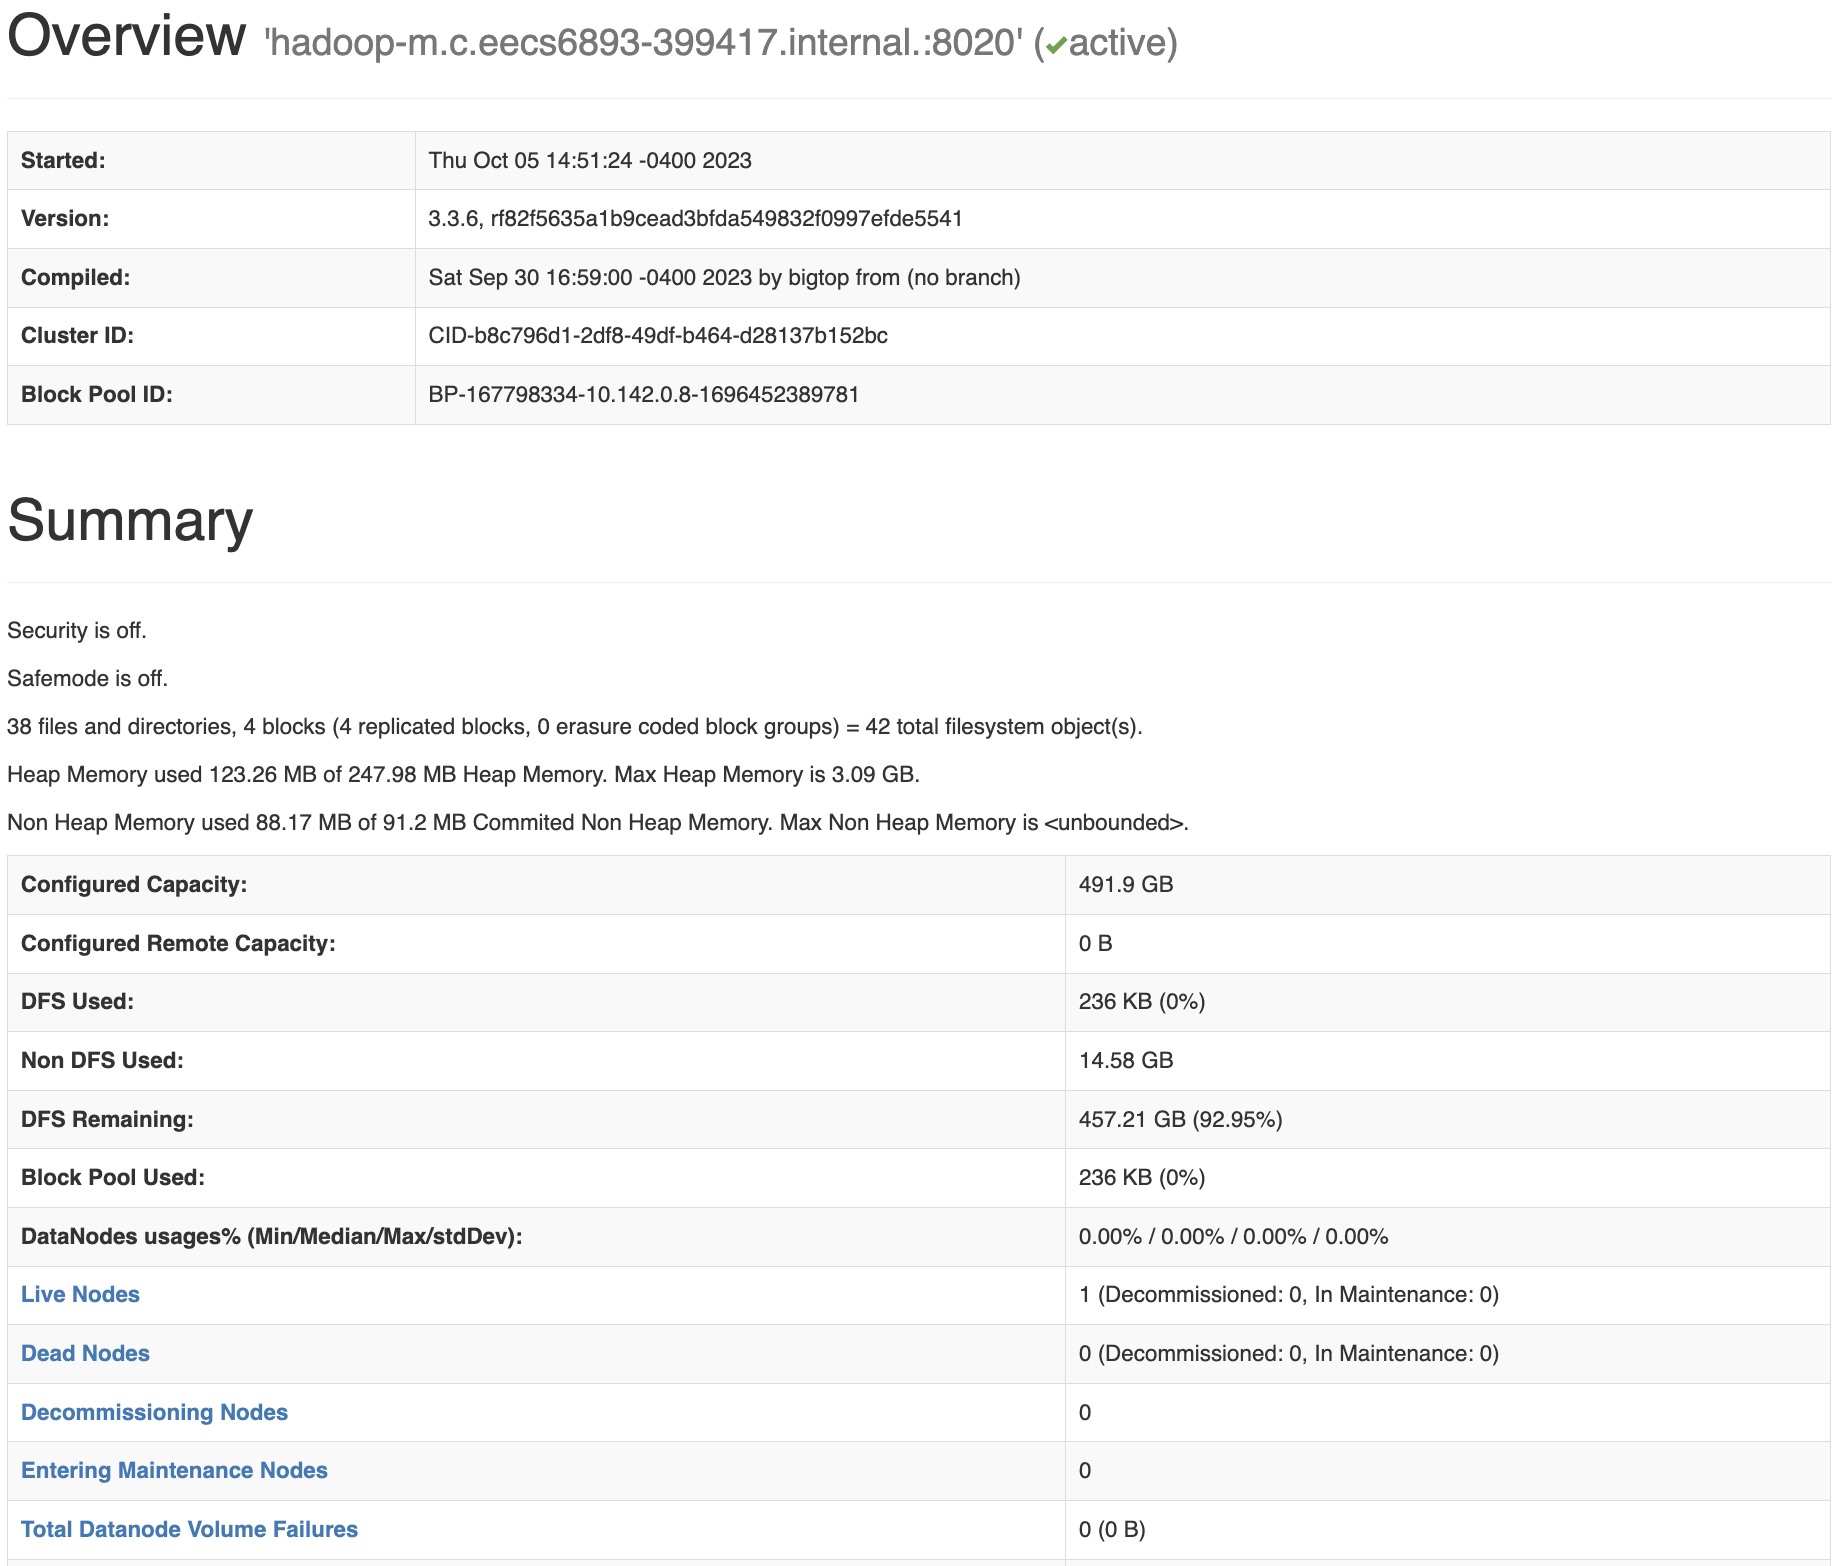

Five important metrics:
1. Used Capacity: The amount of storage capacity currently used by HDFS for storing data. Monitoring used capacity helps ensure that you do not run out of storage space unexpectedly. It is essential for capacity planning and identifying when additional storage is required.
2. Capacity: The total storage capacity available in the HDFS cluster. Understanding the total storage capacity of the cluster is crucial for planning and scaling the infrastructure as needed. It helps determine when it's time to expand the cluster's storage.
3. Blocks: The total number of data blocks currently stored in the HDFS cluster. Monitoring the number of blocks can help you assess the overall health of your cluster. A significant increase in the number of blocks might indicate a growing dataset, while a decrease could suggest data loss.
4. Block Pool Used: The amount of storage space used by a specific block pool within the HDFS cluster. In multi-tenancy environments, where different applications or tenants have separate block pools, monitoring the block pool usage helps ensure fair resource allocation and isolate resource consumption.
5. Last Block Report: The timestamp indicating when the last block report was received from DataNodes. Timely block reports are crucial for detecting DataNode failures and ensuring data reliability. Monitoring this metric can help identify potential issues with DataNode health and block replication.

**(3) MapReduce counters monitoring: (7.5%)** 
- Collect MapReduce counters related information through the web UI. Provide a screenshot. (3.75%) 
- Describe how to monitor the execution of MapReduce tasks through related metrics. (3.75%) 

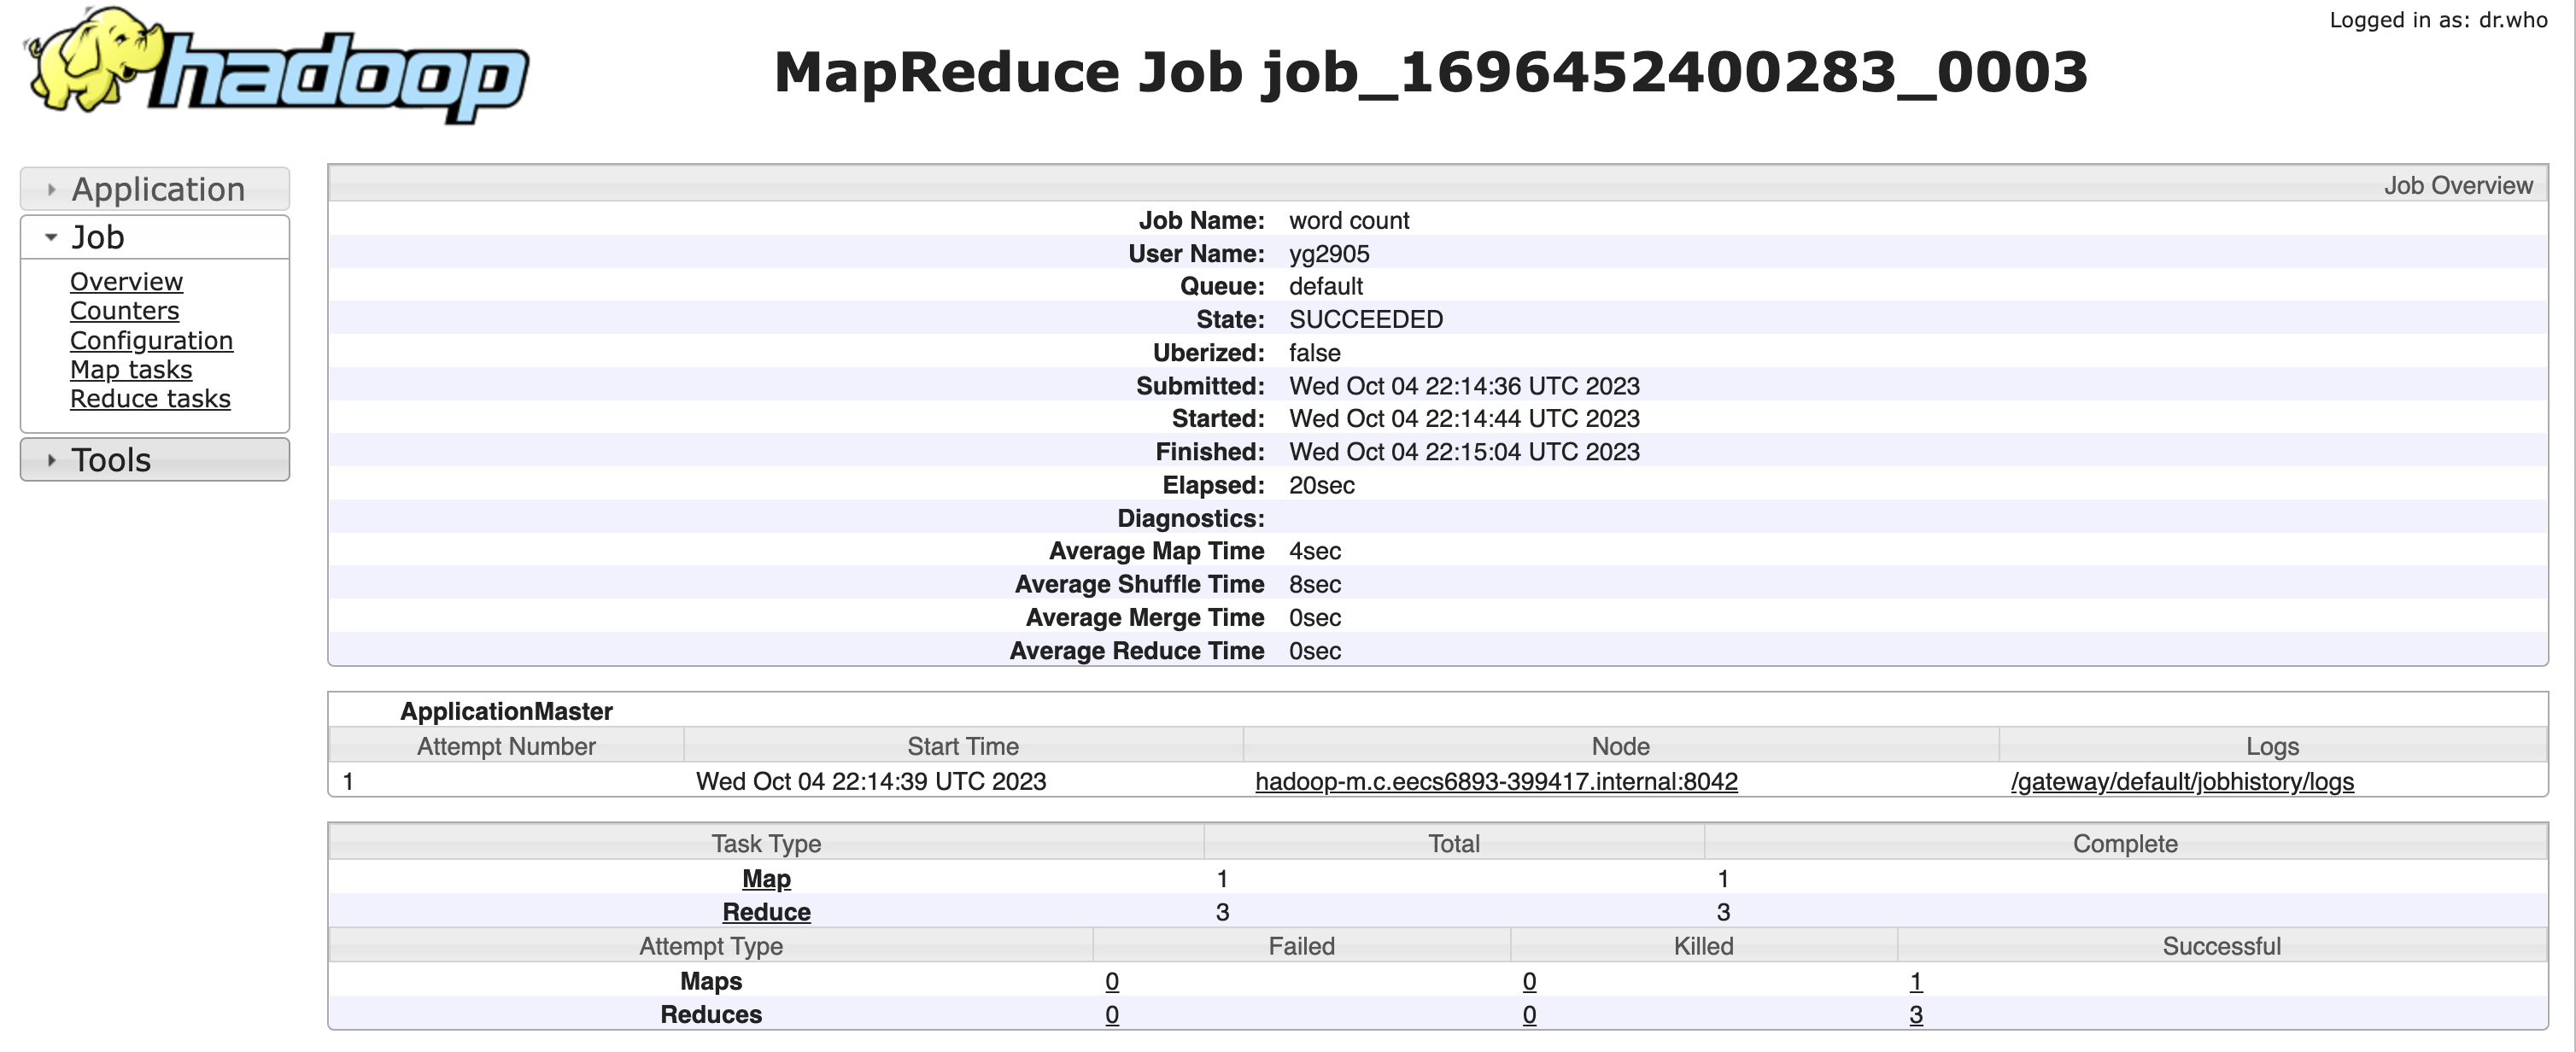
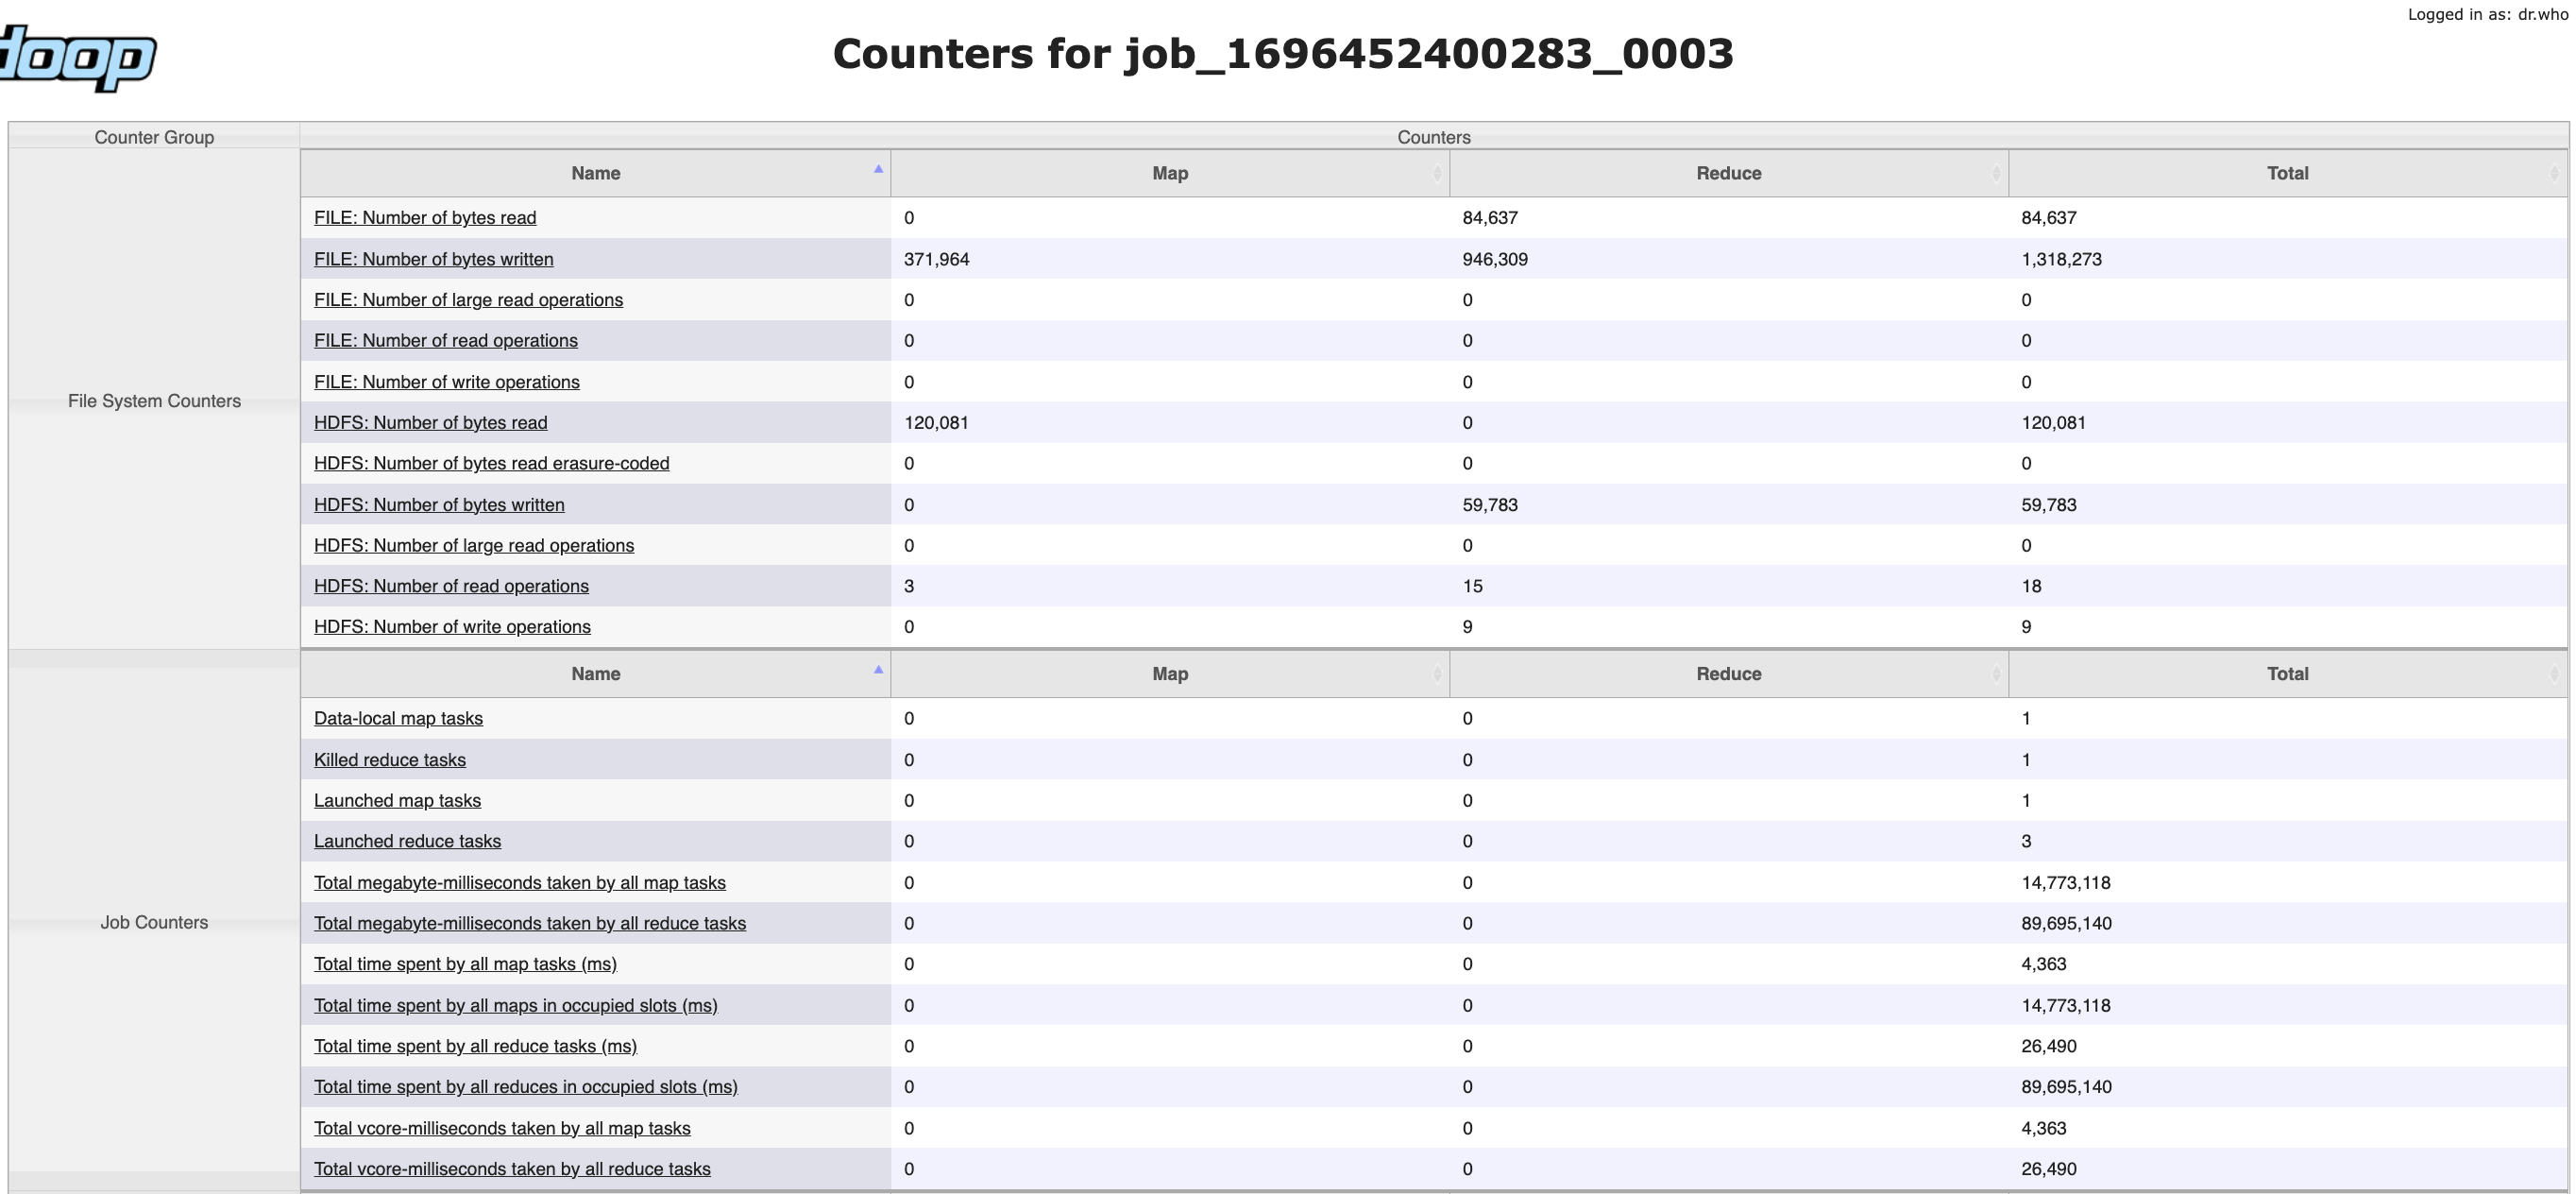
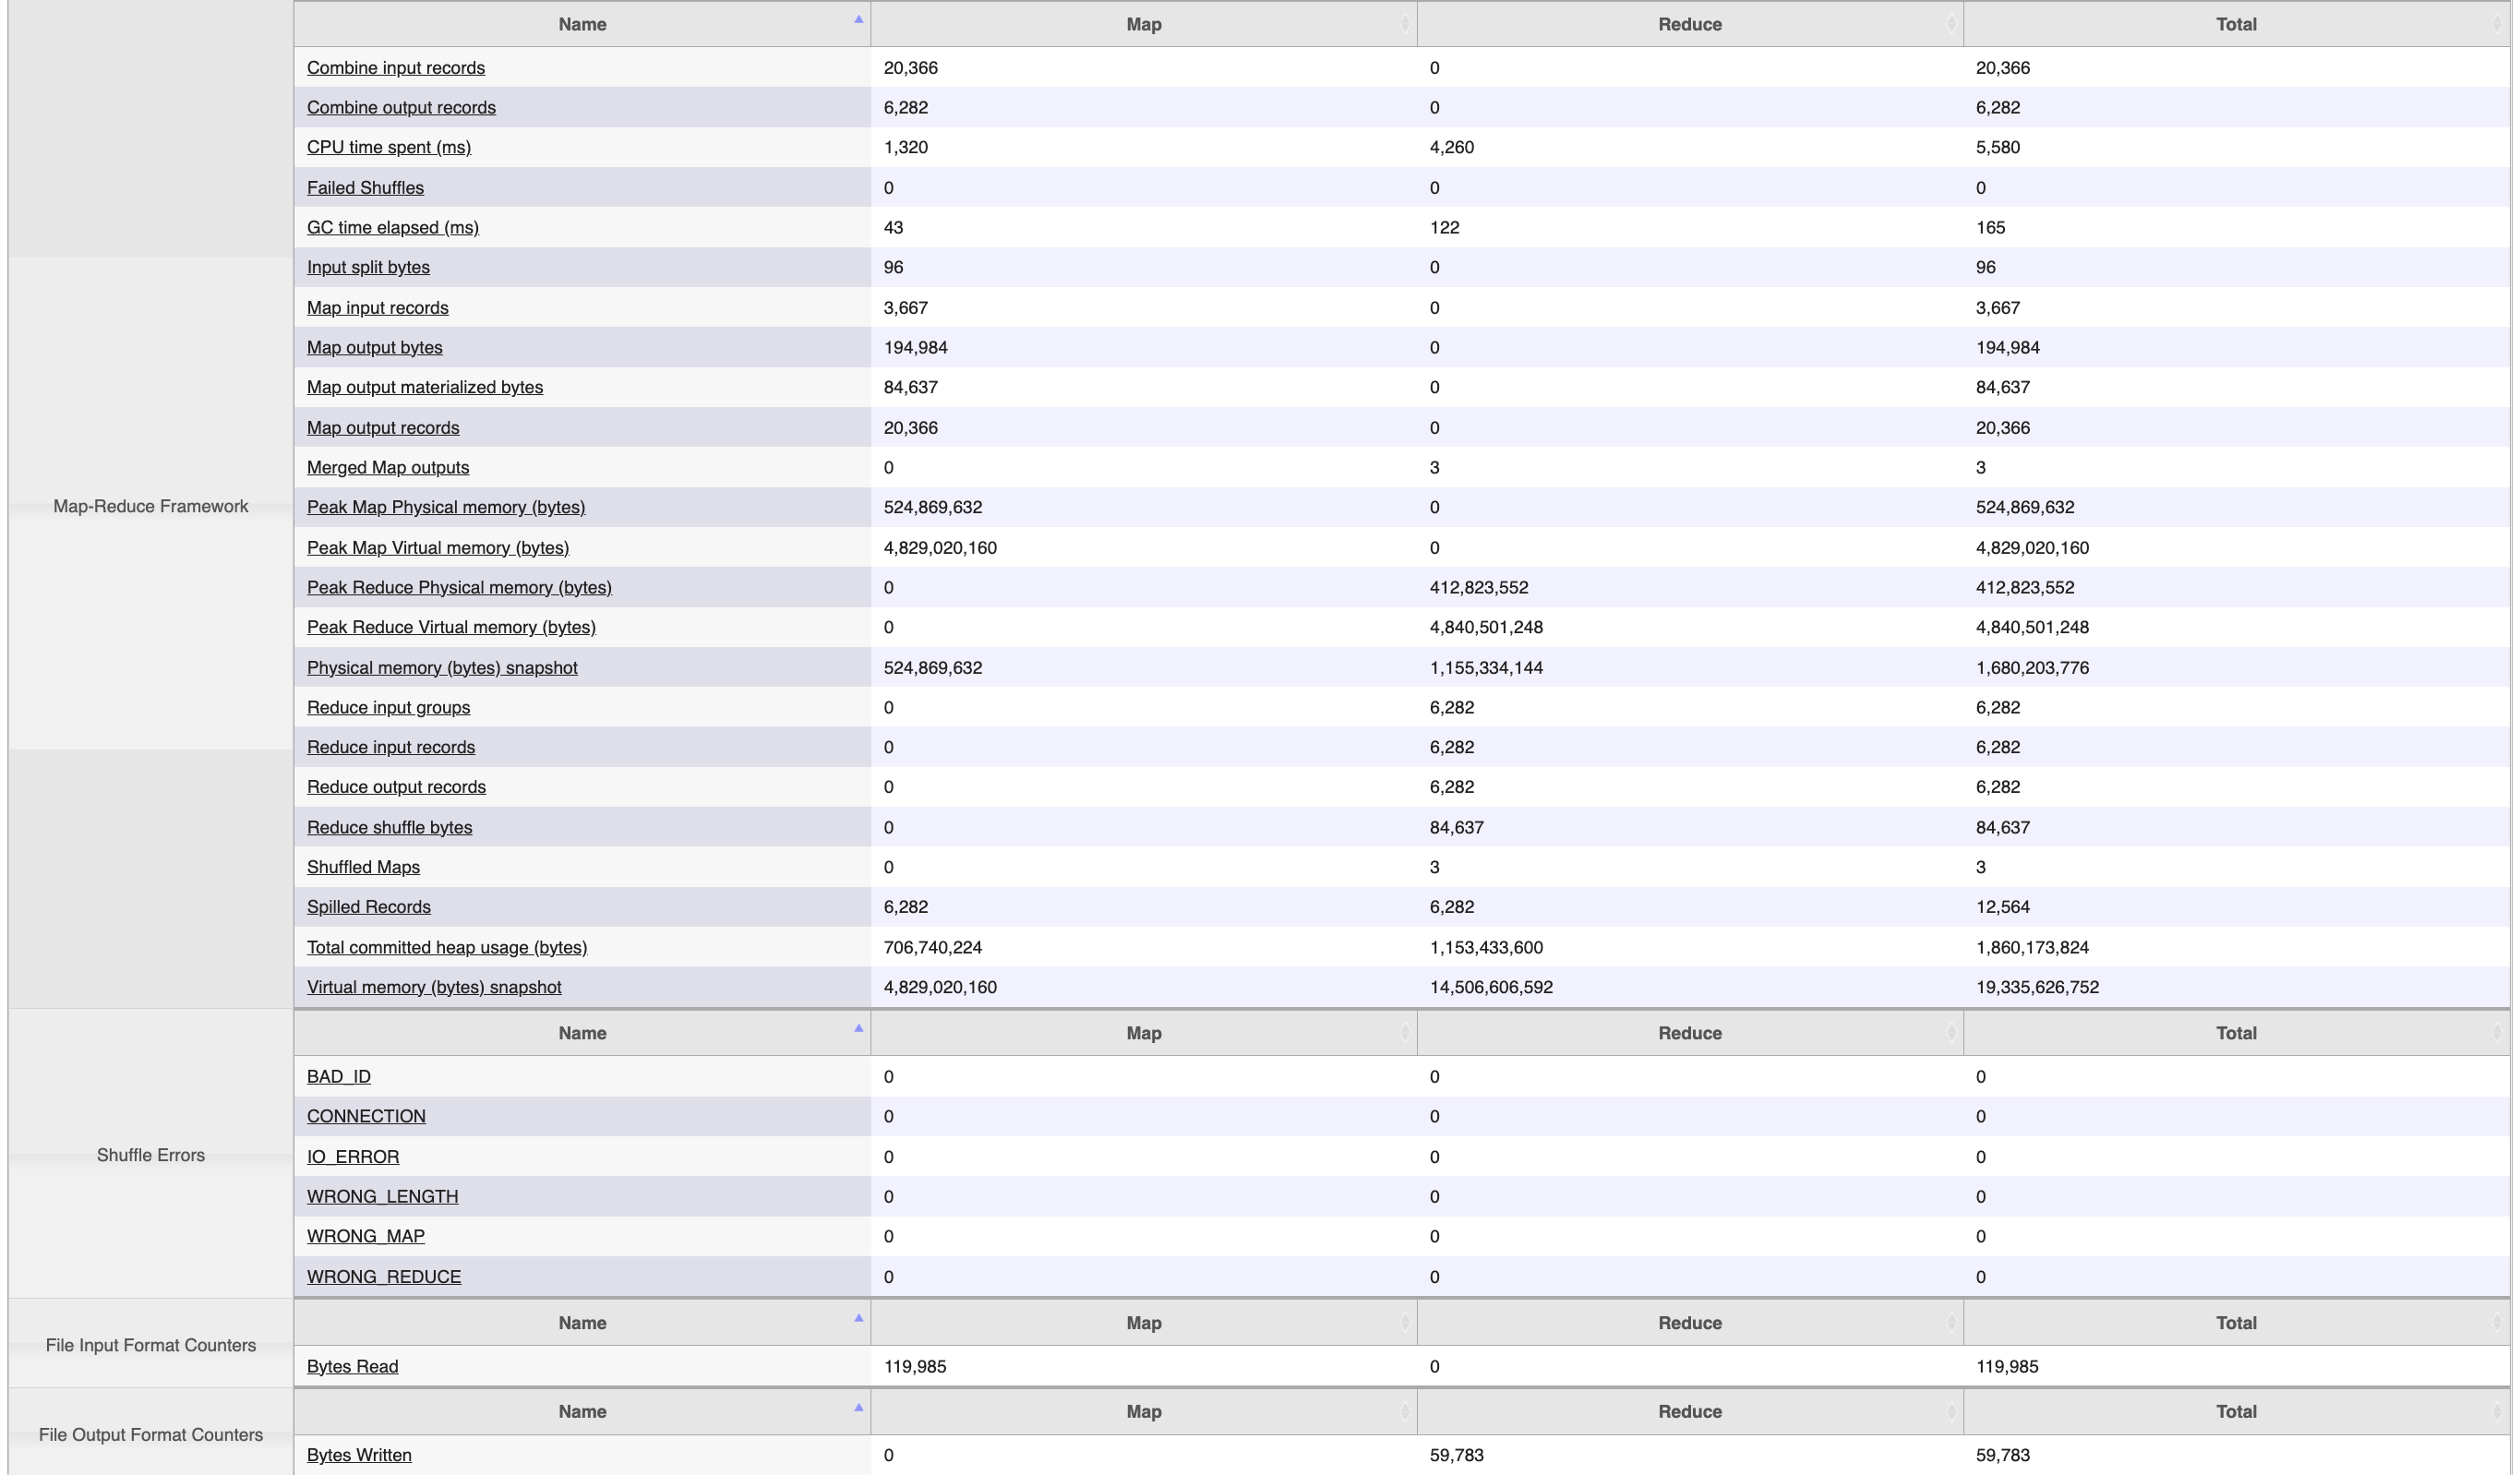

After collect counters associated with the task, we can explore each groups to identify key metrics that are relevant to the monitoring goals. For example:
- Map-Reduce Framework Counters: Map input records: Number of input records processed by Map tasks. Map output records: Number of output records produced by Map tasks. Reduce input groups: Number of unique keys processed by Reduce tasks. Reduce output records: Number of output records produced by Reduce tasks.
- File System Counters: HDFS bytes read: Number of bytes read from HDFS. HDFS bytes written: Number of bytes written to HDFS.
- Job Counters: Launched map tasks: Number of Map tasks launched. Launched reduce tasks: Number of Reduce tasks launched. Data-local map tasks: Number of Map tasks that ran on nodes where the input data was located

**(4) YARN metrics monitoring: (7.5%)**
- Monitor YARN metrics through HTTP API. Provide a screenshot in your report. (3.75%) 
- Select five metrics that you think are most important from the returned json. Explain their usages and why they are important. (3.75%)

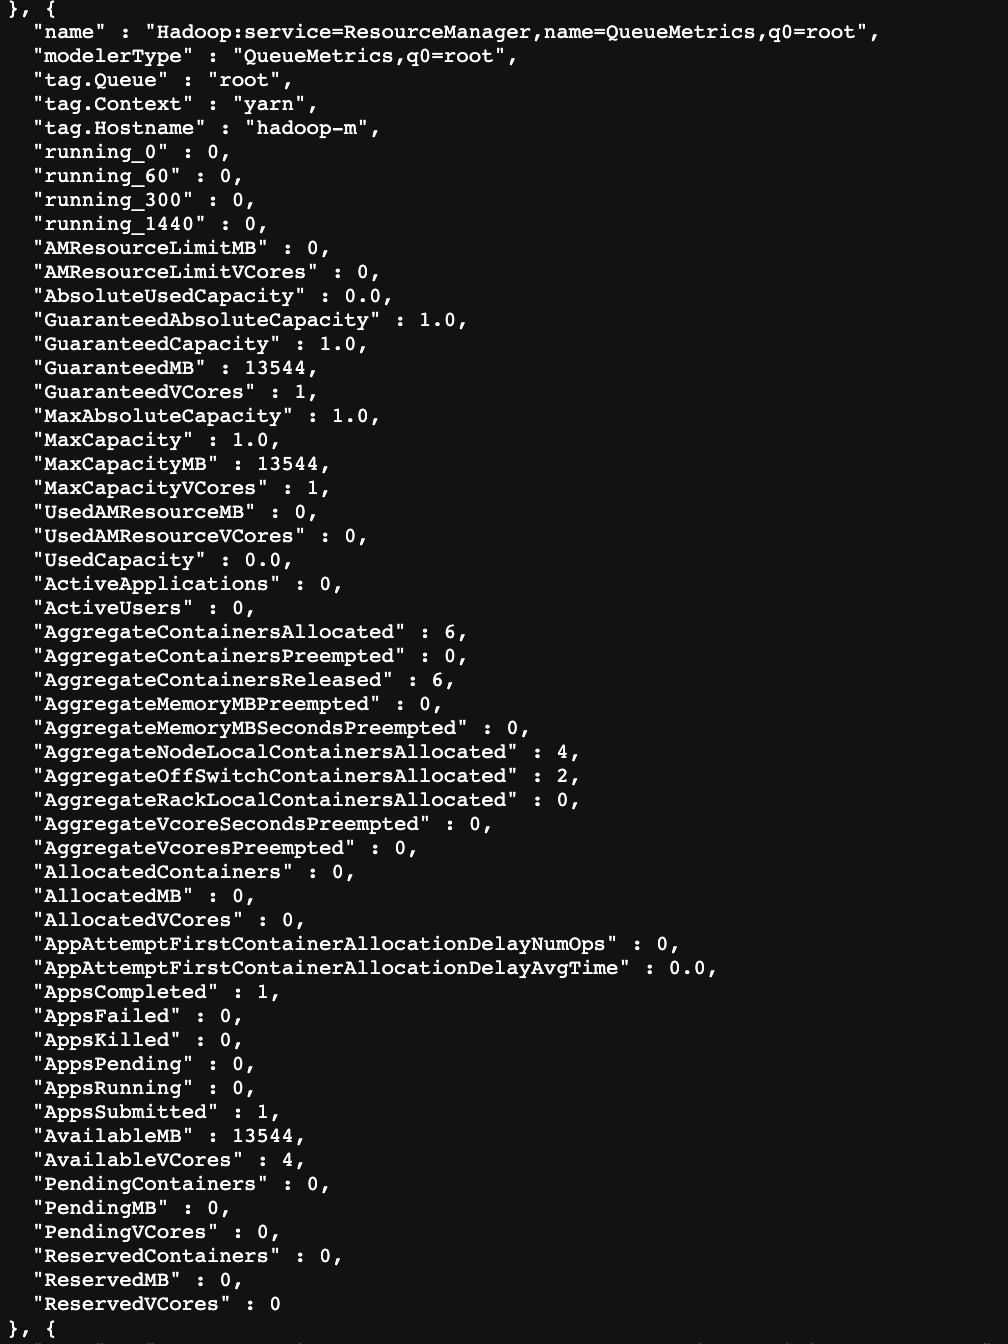
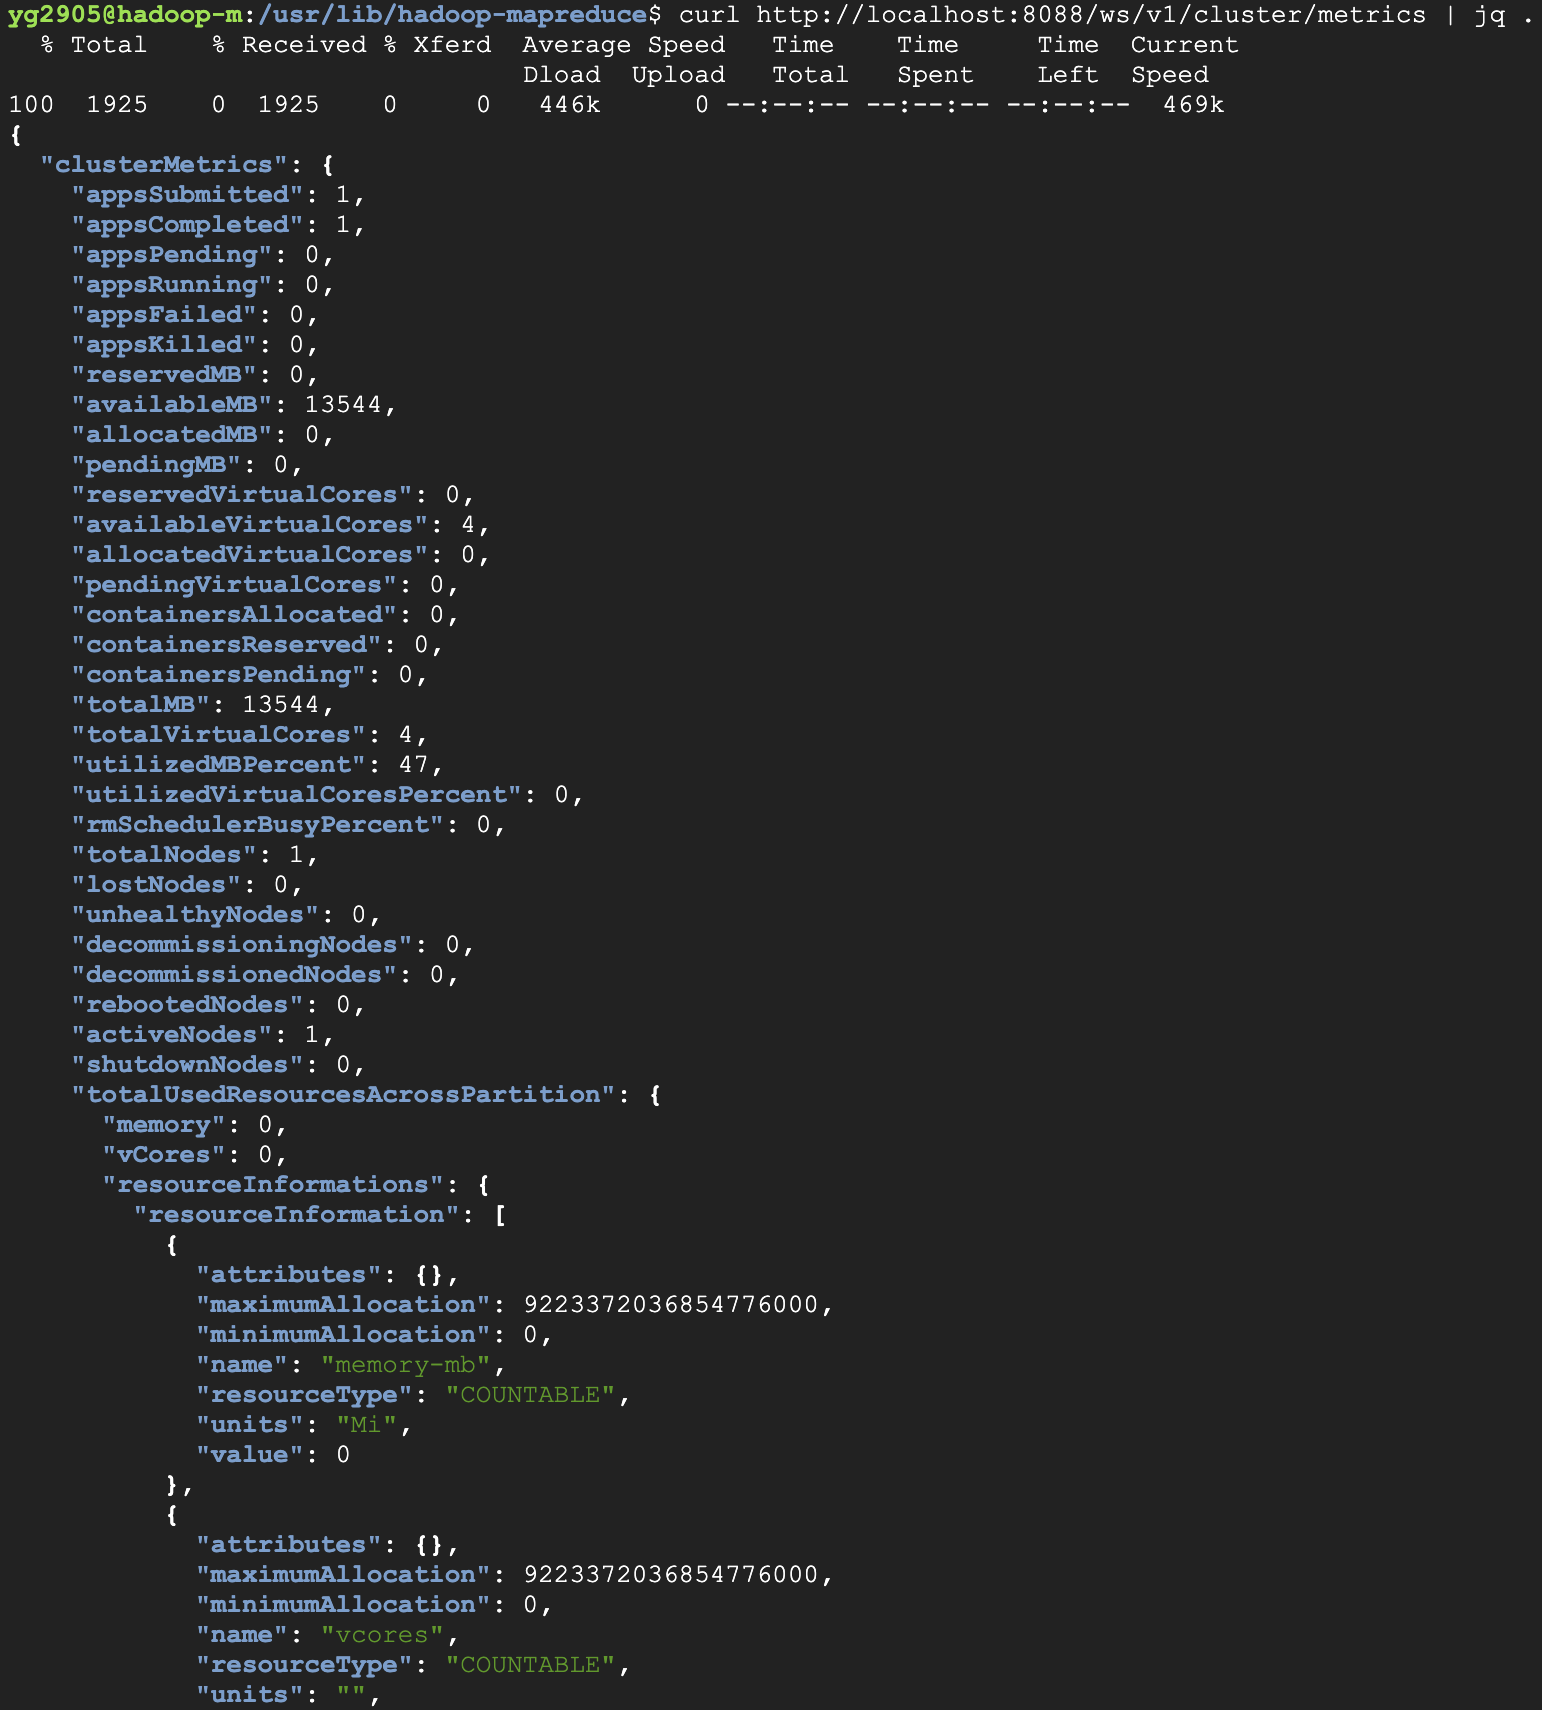

Five important YARN metrics:
- Allocated Containers: The number of containers currently allocated across the YARN cluster. Monitoring the number of allocated containers helps assess the resource utilization and workload of the cluster. It's crucial for optimizing resource allocation and ensuring that applications get the resources they need.
- Available Virtual Cores: The number of virtual cores that are currently available for allocation across the YARN cluster. Tracking available virtual cores helps in capacity planning and ensures that there are sufficient resources for applications requiring CPU processing. It assists in avoiding resource contention and optimizing job performance.
- Pending Applications: The number of applications that are currently in a pending state, waiting for resources. Monitoring pending applications is essential for assessing the demand for resources in the cluster. It helps in identifying potential bottlenecks and optimizing the cluster's configuration to handle increased workloads.
- AM Container Launch Duration: The time taken to launch Application Master (AM) containers. The AM Container Launch Duration is critical for understanding the efficiency of launching Application Masters. Prolonged launch times may impact job performance, and monitoring this metric aids in optimizing cluster performance.
- Failed Container Attempts: The number of container attempts that have failed. Monitoring failed container attempts is crucial for identifying issues with job execution. A high number of failed attempts may indicate problems with resource availability or application issues, and addressing these can enhance the overall reliability of the YARN cluster.